In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from scipy.ndimage import binary_fill_holes
from skimage.measure import label
from skimage.filters import sobel, gaussian
from project.utils import labels2binary, kernel, seg_weights_2D

In [4]:
# Define a few useful functions
def range_01(mat):
    mat_01 = (mat - np.min(mat))/(np.max(mat) - np.min(mat))
    mat_0255 = mat_01*255
    return(mat_0255.astype('uint16'))

We can load images and segmentation. The segmentation are the ground truth segmented cells, that were manually annotated and where errors were removed or corrected. The process was done with the graphical user interface of NAPARI program, using the brush to draw cell contours. The initial segmentation on which we based ourselves was generated with CellPos program, and was not used anywhere else in the project.  

In [5]:
image_file = 'data/_fullmovie_images.tif'
# Hereafter, the manually annotated training set for segmentation 
seg_file = 'data/ground_truth/segmentation/training_set_curated.tif'

cv2 packages allows to retrieve all frame in a list with `cv2.imreadmulti` or a single one with `cv2.imread`

In [6]:
# Load images
_, img_l = cv2.imreadmulti(image_file, [], cv2.IMREAD_ANYDEPTH)
# Load segmentation labels 
_seg, seg_l = cv2.imreadmulti(seg_file, [], cv2.IMREAD_ANYDEPTH)

### Generate custom weights 

In [7]:
# This is the function to generate our custome weights 
def custom_weights_1(I_s, sigma_gaussian = 2.0, n_rounds_gaussian=20, quant_filt = 0.95, final_power = 6):
    sob_s = sobel(I_s)
    
    # First we apply multiple rounds of gaussian blur
    for i in range(n_rounds_gaussian):
        sob_s += gaussian(sob_s, sigma=sigma_gaussian, preserve_range=True)

    # Second, we only keep highest values (tend to overrepresent intersection between cells)
    quant_threshold = np.quantile(sob_s[sob_s > 0], q=quant_filt)
    sob_s[sob_s < quant_threshold] = 0
    # We give pixel inside cells a minimum value
    cell_score = min(sob_s[sob_s > 0])
    sob_s[I_s == 1] += cell_score

    # We reverse the image and do similar filtering : This allow to get the pixels in-between cells
    sob_s[sob_s > 0] = 1/sob_s[sob_s > 0]
    quant_threshold = np.quantile(sob_s[sob_s > 0], q=quant_filt)
    sob_s[sob_s > quant_threshold] = 0
    cell_score = min(sob_s[sob_s > 0])
    sob_s[I_s == 1] += cell_score
    
    # We reverse again to the original 
    sob_s[sob_s > 0] = 1/sob_s[sob_s > 0]

    # We expend to a power to exagerate differences 
    sob_s = sob_s**final_power
    
    # Normalize between 0 and 255
    sob_s = (sob_s - np.min(sob_s))/(np.max(sob_s) - np.min(sob_s)) * 255

    return(sob_s)

Example of weights on a zoom on a few cell compared with segmentation and raw image. This is typically the kind of places where segmentation and tracking are difficult.

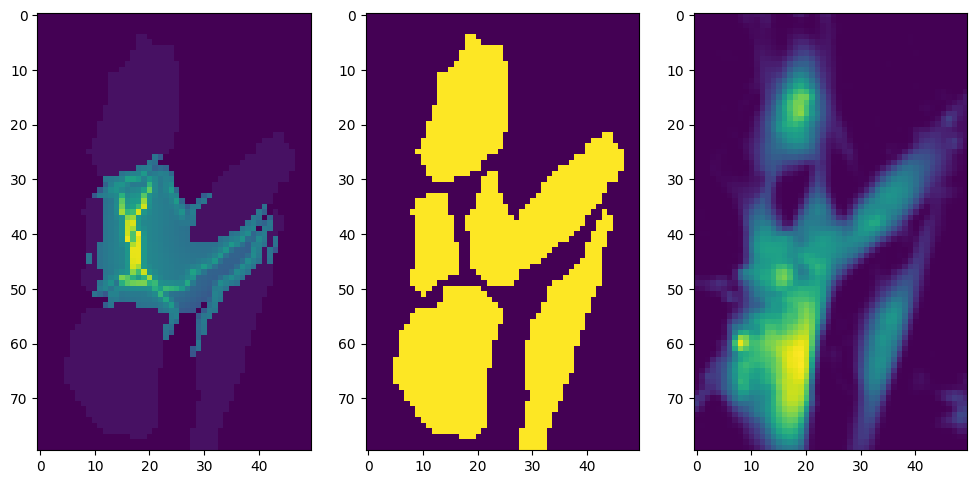

In [9]:
fig,axs=plt.subplots(1,3,figsize=(12,8),dpi=100)
axs[0].imshow(custom_weights_1(seg_l[0][50:130, 450:500].copy(), 
                            sigma_gaussian=5.0, n_rounds_gaussian=5, 
                            quant_filt = 0.85, final_power=5))
axs[1].imshow(seg_l[0][50:130, 450:500].copy())
axs[2].imshow(img_l[0][50:130, 450:500].copy())

### Build Training set for cell segmentation 

It is __CRUCIAL__ to use `labels2binary` and `binary_fill_holes` on the segmentation before tracing as the script relies on automatic labelling with `skimage.measure.label` which will make a single cell out of every neighboring cells that touch each other. This labelling is what allow us to retrieve the link between cells and between time points. 

In [12]:
# Parameters used for custom weights 
sigma=5.0
q=0.85
pow_=5

# Creating output dir to write ground truth segmentation for training with associated images and weights
out_dir = "data/training_segmentation_new/"
if not os.path.exists(out_dir):
    os.mkdir(out_dir) ; os.mkdir(out_dir + 'seg') ; os.mkdir(out_dir + 'img') ; os.mkdir(out_dir + 'wei')

for f in range(0, 125): # iterate over frames
    I = img_l[f][0:512, 0:512].copy()
    I_seg = seg_l[f][0:512, 0:512].copy()

    # Get output name in DELTA compatible format
    out_name = "Sample0000" + str(f) + ".png"
    if f > 9:
        out_name = "Sample000" + str(f) + ".png"
    if f > 99:
        out_name = "Sample00" + str(f) + ".png"

    # Binarize and remove touching borders:
    mask = labels2binary(I_seg)
    # Fill holes in mask:
    mask = binary_fill_holes(mask)
    # Convert to uint8:
    mask = mask.astype(np.uint8)
    mask[mask > 0] = 255
    # Generate a weights map with the "new" method:
    wei = custom_weights_1(mask.copy(), 
                            sigma_gaussian=sigma, n_rounds_gaussian=4, 
                            quant_filt = q, final_power=pow_)
    wei = range_01(wei).astype(np.uint8)

    cv2.imwrite(out_dir + "img/" + out_name, I)
    cv2.imwrite(out_dir + "seg/" + out_name, mask)
    cv2.imwrite(out_dir + "wei/" + out_name, wei)

### Build Training set used to optimize custom weights

To be able to optimize our weighting scheme, we generated multiple combination of image processing parameter used in our custom weight function to train Delta with. 

In [58]:
# Hereafter, the definition of the input params to build custom weights
def add_vals(d, i, sigma, q, pow_):
    d[i] = {}
    d[i]['sigma'] = sigma
    d[i]['q'] = q
    d[i]['pow'] = pow_
    return(d)

in_params = {}
# Hereafter , all the combination of sigma, q and pow parameters
in_params = add_vals(in_params, 0, sigma=0.8, q=0.98, pow_=3)
in_params = add_vals(in_params, 1, sigma=0.8, q=0.98, pow_=4)
in_params = add_vals(in_params, 2, sigma=1.0, q=0.98, pow_=3)
in_params = add_vals(in_params, 3, sigma=1.0, q=0.98, pow_=4)
in_params = add_vals(in_params, 4, sigma=2.0, q=0.98, pow_=3)
in_params = add_vals(in_params, 5, sigma=2.0, q=0.98, pow_=4)
in_params = add_vals(in_params, 6, sigma=2.0, q=0.95, pow_=4)
in_params = add_vals(in_params, 7, sigma=3.0, q=0.95, pow_=5)
in_params = add_vals(in_params, 8, sigma=4.0, q=0.90, pow_=5)
in_params = add_vals(in_params, 9, sigma=5.0, q=0.85, pow_=5)

In [64]:
# We iterate over combination of parameters to generate a training set 
for key in in_params.keys():
    sigma=in_params[key]['sigma']
    q=in_params[key]['q']
    pow_=in_params[key]['pow']

    out_dir = "data/build_example_training_set/training_seg_CustomWeights_sig{0}_q{1}_pow{2}/".format(str(sigma).replace('.',''),str(q).replace('.',''), str(pow_).replace('.',''))
    if not os.path.exists(out_dir):
        os.mkdir(out_dir) ; os.mkdir(out_dir + 'seg') ; os.mkdir(out_dir + 'img') ; os.mkdir(out_dir + 'wei')
        
    print('Generating training set for parameters : sigma = ', sigma, ', q = ', q, ', pow = ', pow_)
    print('in folder : ', out_dir)
    idx=0   
    for f in range(0, 125): # iterate over frames
        I = img_l[f][0:512, 0:512].copy()
        I_seg = seg_l[f][0:512, 0:512].copy()

        # Get output name
        out_name = "Sample0000" + str(idx) + ".png"
        if idx > 9:
            out_name = "Sample000" + str(idx) + ".png"
        if idx > 99:
            out_name = "Sample00" + str(idx) + ".png"

        # Binarize and remove touching borders:
        mask = labels2binary(I_seg)
        # Fill holes in mask:
        mask = binary_fill_holes(mask)
        # Convert to uint8:
        mask = mask.astype(np.uint8)
        mask[mask > 0] = 255
        # Generate a weights map with the "new" method:
        wei = custom_weights_1(mask.copy(), 
                                sigma_gaussian=sigma, n_rounds_gaussian=4, 
                                quant_filt = q, final_power=pow_)
        wei = range_01(wei).astype(np.uint8)

        cv2.imwrite(out_dir + "img/" + out_name, I)
        cv2.imwrite(out_dir + "seg/" + out_name, mask)
        cv2.imwrite(out_dir + "wei/" + out_name, wei)
        idx+=1

Generating training set for parameters : sigma =  0.8 , q =  0.98 , pow =  3
in folder :  data/build_example_training_set/training_seg_CustomWeights_sig08_q098_pow3/
Generating training set for parameters : sigma =  0.8 , q =  0.98 , pow =  4
in folder :  data/build_example_training_set/training_seg_CustomWeights_sig08_q098_pow4/
Generating training set for parameters : sigma =  1.0 , q =  0.98 , pow =  3
in folder :  data/build_example_training_set/training_seg_CustomWeights_sig10_q098_pow3/
Generating training set for parameters : sigma =  1.0 , q =  0.98 , pow =  4
in folder :  data/build_example_training_set/training_seg_CustomWeights_sig10_q098_pow4/
Generating training set for parameters : sigma =  2.0 , q =  0.98 , pow =  3
in folder :  data/build_example_training_set/training_seg_CustomWeights_sig20_q098_pow3/
Generating training set for parameters : sigma =  2.0 , q =  0.98 , pow =  4
in folder :  data/build_example_training_set/training_seg_CustomWeights_sig20_q098_pow4/
Gene

From the multiple training set above, we selected the one with parameters sigma =  5.0 , q =  0.85 , pow =  5 as the best performer and kept it for next steps.

### Make testing set for cell tracking :

In [40]:
# This is a work around to work with the image subsets we have :
label_file = "data/training_tracking/training_labels_originals_curated.tif"
_,labels = cv2.imreadmulti(label_file, [], cv2.IMREAD_ANYDEPTH)

In [48]:
I_seg = labels[120].copy()

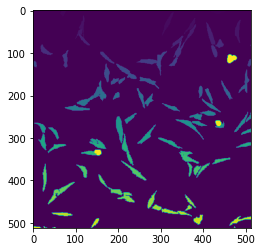

In [49]:
plt.imshow(I_seg)

It is __CRUCIAL__ to use `labels2binary` and `binary_fill_holes` on the segmentation before tracing as the script relies on automatic labelling with `skimage.measure.label` which will make a single cell out of every neighboring cells that touch each other. This labelling is what allow us to retrieve the link between cells and between time points. 

In [50]:
# Binarize and remove touching borders:
mask = labels2binary(I_seg)
# Fill holes in mask:
mask = binary_fill_holes(mask)

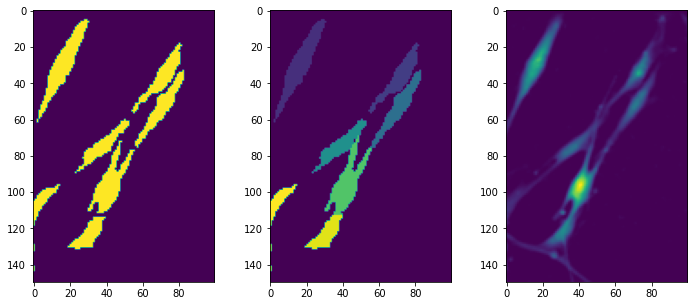

In [58]:
fig, axs = plt.subplots(1,3, figsize=(12,5))
axs[0].imshow(mask[0:150,300:400])
axs[1].imshow(I_seg[0:150,300:400])
axs[2].imshow(frame_data[120][0:150,300:400])

In [78]:
binary_mask = np.zeros((125,512,512))
out_dir = 'delta_dev_branch/delta/testing_tracking_1/'
for f in range(len(labels)):
    Img = frame_data[f][0:512,0:512].copy()
    I_lab = labels[f].copy()
    # Binarize and remove touching borders:
    mask = labels2binary(I_lab)
    # Fill holes in mask:
    mask = binary_fill_holes(mask).astype('uint8')
    mask[mask > 0] = 255
    binary_mask[f] = mask
    
    # Write files
    # Get output name
    out_name = "Position01Channel01Frame0000" + str(f) + ".png"
    if f > 9:
        out_name = "Position01Channel01Frame000" + str(f) + ".png"
    if f > 99:
        out_name = "Position01Channel01Frame00" + str(f) + ".png"

    # Write results in folder 
    cv2.imwrite(out_dir + "img/" + out_name, Img)
    cv2.imwrite(out_dir + "seg/" + out_name, mask)

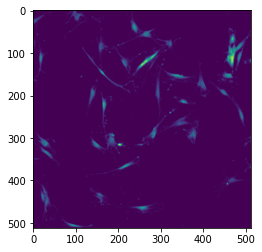

In [56]:
plt.imshow(frame_data[0][0:512,0:512])

In [54]:
imageio.mimwrite('data/training_tracking/training_binaryMask_originals_curated.tif', binary_mask)

In [ ]:
### Generate weights for images 

import skimage.morphology as morph

# 3x3 square kernel for morphological operations:
kernel_full33 = np.array(
    [[1,1,1],
     [1,1,1],
     [1,1,1]],
    np.uint8
    )

def labels2binary(labels):

    # Empty binary mask:
    binary = labels>0

    # Cell indexes in image:
    cell_nbs = np.unique(labels[binary])

    # Run through cells:
    for cell in cell_nbs:

        # single cell mask:
        single_cell = labels == cell
        single_cell = single_cell.astype(np.uint8)

        # Contour mask dilated by 1 pixel:
        single_cell_contour = cv2.dilate(
            single_cell,kernel_full33,iterations = 1
            )
        single_cell_contour -= single_cell

        # remove borders where cells are touching:
        binary[single_cell_contour>0]=False

    return binary.astype(np.uint8)

def kernel(n):
    '''
    

    Parameters
    ----------
    n : Int
        Determine size of kernel.

    Returns
    -------
    kernel : Array of unit8
        Returns a kernal with size of n.

    '''
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(n,n))
    return kernel


def seg_weights_2D(mask, classweights=(1,1)):
    '''
    This function computes custom weightmaps designed for bacterial images where borders are difficult to distinguish
    
    Parameters
    ----------
    mask : 2D array
        Training output segmentation mask.
    classweights : tuple of 2 int/floats, optional
        Weights to apply to cells and border
        The default is (1,1)
      

    Returns
    -------
    weightmap : 2D array
        Weights map image.

    '''
    if mask.ndim == 3:
        mask = mask[:,:,0]
    if np.max(mask) == 255:
        mask = mask / 255
        
    # Extract all pixels that include the cells and it's border 
    border = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,kernel(20)) 
    # Set all pixels that include the cells to zero to leave behind the border only
    border[mask>0] = 0   
    
    # Erode the segmentation to avoid putting high emphasiss on edges of cells 
    mask_erode = cv2.erode(mask,kernel(2))   
    
    # Get the skeleton of the segmentation and border
    mask_skel = morph.skeletonize(mask_erode > 0)  
    border_skel = morph.skeletonize(border > 0)  
    
    # Find the distances from the skeleton of the segmention and border
    s , border_dist = morph.medial_axis(border_skel < 1, return_distance=True)  
    s , mask_dist = morph.medial_axis(mask_skel < 1, return_distance=True)      
    
    # Use the distance from the skeletons to create a gradient towards the skeleton
    border_gra = border * (classweights[1]) / (border_dist + 1)**2             
    mask_gra = (mask/ (mask_dist + 1)**2)
        
    # Set up weights array
    weightmap = np.zeros((mask.shape),dtype=np.float32)
    
    # Add the gradients for the segmentation and border into the weights array
    weightmap[mask_erode>0] = mask_gra[mask_erode>0] 
    weightmap[border>0] = border_gra[border>0] 
    
    # Set the skeletons of the segmentation and borders to the maximum values
    weightmap[mask_skel>0] = classweights[0]
    weightmap[border_skel>0] = classweights[1]
        
    # Keep the background zero and set the erode values in the seg/border to a minimum of 1
    bkgd = np.ones((mask.shape)) - mask - border
    weightmap[((weightmap == 0) * (bkgd < 1))] = 1 / 255
    
    return weightmap


def seg_weights(mask, classweights=(1,1), w0=12, sigma=2):
    '''
    This function computes the weight map as described in the original U-Net
    paper to force the model to learn borders 
    (Slow, best to run this offline before training)

    Parameters
    ----------
    mask : 2D array
        Training output segmentation mask.
    classweights : tuple of 2 int/floats
        Weights to apply to background, foreground.
        The default is (1,1)
    w0 : int or float, optional
        Base weight to apply to smallest distance (1 pixel). 
        The default is 12.
    sigma : int or float, optional
        Exponential decay rate to apply to distance weights.
        The default is 2.

    Returns
    -------
    weightmap : 2D array
        Weights map image.

    '''

    # Get cell labels mask:
    lblimg,lblnb = label(mask,connectivity=1,return_num=True)
    
    # Compute cell-to-cell distance masks:
    distance_array = float('inf')*np.ones(mask.shape[0:2] + (max(lblnb,2),))
    for i in range(0,lblnb):
        _, distance_array[:,:,i] = morph.medial_axis(
            (lblimg==i+1)==0,return_distance=True
            )
    
    # Keep 2 smallest only:
    distance_array = np.sort(distance_array,axis=-1)[:,:,0:2]
    
    # Compute weights map:
    weightmap = w0*np.exp(-np.square(np.sum(distance_array,-1))/(2*sigma^2))
    weightmap = np.multiply(weightmap,mask==0)
    weightmap = np.add(weightmap,(mask[:,:]==0)*classweights[0])
    weightmap = np.add(weightmap,(mask[:,:]==1)*classweights[1])
    
    return weightmap

